# Structured hierarchical models

The goal of this project is to model essential genes for multiple conditions given that we have prior knowledge about functional relations of these genes. We extend the model from before to:

\begin{align}
\boldsymbol \pi & \sim \text{Dirichlet}(0.5, 0.5) \\
z_g & \sim \text{Categorical}(\boldsymbol \pi) \\
\tau^2 & \sim P(\cdot) \\
\mu_{z_g} & \sim \mathcal{N}(0, 1) \\
\gamma_g \mid z_g &  \sim \mathcal{N}(\mu_{z_g}, \tau^2) \\
\beta_{vg} \mid \gamma_g &  \sim \mathcal{N}(\gamma_g, \tau^2) \\
l_{vg} & \sim \text{Gamma}(1, 1) \\
x_{svg} \mid \beta_{vg} &  \sim \text{Pois}\left(l_{vg} \cdot \exp \left( \beta_{vg} \right) \right) \\
\end{align}

In [ ]:
N = 1000

W = np.array([0.35, 0.4, 0.25])

MU = np.array([0., 2., 5.])
SIGMA = np.array([0.5, 0.5, 1.])


In [1]:
import warnings
warnings.filterwarnings("ignore")

In [2]:
import pandas as pd
import pymc3 as pm
import numpy as np
import scipy as sp
import theano.tensor as tt

In [3]:
from sklearn import preprocessing
from pymc3 import  model_to_graphviz

In [4]:
%matplotlib inline
from matplotlib import pyplot as plt
import seaborn as sns
import arviz as az

sns.set_style(
    "white", 
    {'xtick.bottom': True,
     'ytick.left': True,
     'axes.spines.top': False, 
     'axes.spines.right': False})

## Test

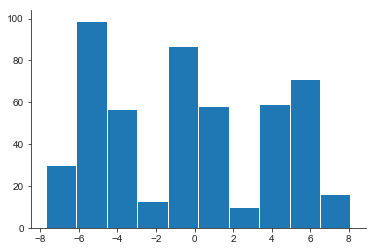

In [62]:
k = 3
ndata = 500
spread = 5
centers = np.array([-spread, 0, spread])

v = np.random.randint(0, k, ndata)
data = centers[v] + np.random.randn(ndata)
plt.hist(data);

In [121]:
model = pm.Model()
with model:
    p = pm.Dirichlet('p', a=np.array([1., 1., 1.]), shape=k)
    p_min_potential = pm.Potential('p_min_potential', tt.switch(tt.min(p) < .1, -np.inf, 0))
    
    means = pm.Normal('means', mu=[0, 0, 0], sd=15, shape=k)    
    order_means_potential = pm.Potential(
        'omp', tt.switch(means[1] - means[0] < 0, -np.inf, 0) + \
               tt.switch(means[2] - means[1] < 0, -np.inf, 0))    
    sd = pm.Uniform('sd', lower=0, upper=20)
    
    category = pm.Categorical('category', p=p, shape=ndata)

    points = pm.Normal('obs', mu=means[category], sd=sd, observed=data)

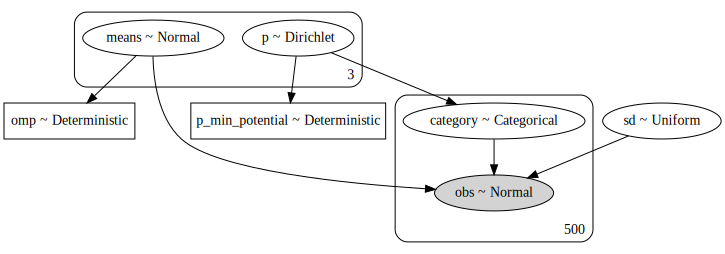

In [64]:
model_to_graphviz(model)

In [66]:
with model:    
    trace = pm.sample(5000, n_init=10000, tune=1000, chains=2, init="advi", random_seed=seed)

Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>NUTS: [sd, means, p]
>CategoricalGibbsMetropolis: [category]
Sampling 2 chains: 100%|██████████| 12000/12000 [06:35<00:00, 14.99draws/s]
The acceptance probability does not match the target. It is 0.8822263093011226, but should be close to 0.8. Try to increase the number of tuning steps.


In [71]:
az.effective_sample_size(trace).to_dataframe().loc[0, 0]

,means,category,p,sd
p_dim_0,,,,
0,9098.0,2181.0,9222.0,9478.0
1,9098.0,2181.0,9590.0,9478.0
2,9098.0,2181.0,10280.0,9478.0


In [72]:
az.rhat(trace).to_dataframe().loc[0, 0]

,means,category,p,sd
p_dim_0,,,,
0,1.0,1.0,1.0,1.0
1,1.0,1.0,1.0,1.0
2,1.0,1.0,1.0,1.0


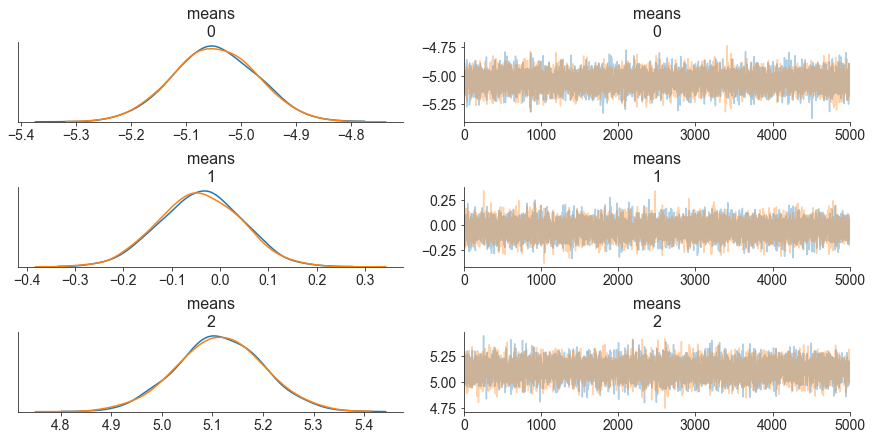

In [74]:
az.plot_trace(trace, var_names=["means"]);

## Simulated data

In [92]:
seed = 42
np.random.seed(seed)

In [93]:
conditions = ["C" + str(i) for i in range(2)]
genes = ["G" + str(i) for i in range(2)]
sgrnas = ["S" + str(i) for i in range(2)]
replicates = ["R" + str(i) for i in range(2)]

In [94]:
combinations = [(g, c, s, r) \
     for g in genes for c in conditions \
     for s in sgrnas for r in replicates]

In [95]:
count_table = pd.DataFrame(
    combinations, 
    columns=["genes", "conditions", "sgrnas", "replicates"])

In [96]:
tau_true = sp.stats.halfcauchy.rvs(0, .1, size=1)
tau_true

array([0.06671342])

In [144]:
gamma_true = sp.array([.6, .5, 5, 6])
gamma_true

array([0.6, 0.5, 5. , 6. ])

In [145]:
beta_true = sp.stats.norm.rvs(
    np.repeat(gamma_true, len(conditions)), tau_true)
beta_true

array([0.62831893, 0.66274635, 0.44211669, 0.50973094, 4.90861121,
       4.94851186, 6.05861932, 5.98401583])

In [146]:
l_true = sp.stats.lognorm.rvs(
    1, size= len(conditions) * len(genes) * 2 * len(sgrnas))
l_true

array([ 3.35141274,  1.71250978, 15.40084163,  1.09830209,  0.24502249,
        0.96605969,  0.38173996,  2.65695306,  1.04287369,  0.87173324,
        0.8832629 ,  2.09664997,  0.63606009,  2.17504596,  2.84502305,
        0.71024755])

In [147]:
l_idx = np.repeat(range(len(l_true)), 3)
l_idx

array([ 0,  0,  0,  1,  1,  1,  2,  2,  2,  3,  3,  3,  4,  4,  4,  5,  5,
        5,  6,  6,  6,  7,  7,  7,  8,  8,  8,  9,  9,  9, 10, 10, 10, 11,
       11, 11, 12, 12, 12, 13, 13, 13, 14, 14, 14, 15, 15, 15])

In [148]:
beta_idx = np.repeat(range(len(beta_true)), 6)
beta_idx

array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
       3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7, 7,
       7, 7, 7, 7])

In [149]:
counts = sp.stats.poisson.rvs(
    l_true[l_idx] * np.exp(beta_true[beta_idx]))
counts

array([   6,    9,   13,    1,    4,    0,   36,   22,   35,    1,    0,
          5,    0,    1,    0,    0,    0,    4,    0,    0,    1,    7,
          2,    1,  148,  123,  140,  116,  122,   92,  129,  138,  112,
        303,  300,  299,  279,  274,  267,  978,  873,  947, 1112, 1108,
       1149,  305,  298,  264])

In [150]:
with pm.Model() as model:
    p = pm.Dirichlet('p', a=np.array([1., 1.]), shape=2)
    p_min_pot = pm.Potential('p_pot', tt.switch(tt.min(p) < .05, -np.inf, 0))
    category = pm.Categorical('category', p=p, shape=4)
    
    tau_g = pm.HalfCauchy('tau_g', 1., shape=1)
    mean_g = pm.Normal('mu_g', mu=np.array([0, 1]), sd=.5, shape=2)
    mean_order_pot = pm.Potential('mop', tt.switch(mean_g[1] - mean_g[0] < 0, -np.inf, 0))    
    gamma = pm.Normal('gamma', mean_g[category], tau_g, shape=4)
    
    tau_b = pm.HalfCauchy('tau_b', 1., shape=1)
    beta = pm.Normal('beta', gamma[np.repeat([0, 1, 2, 3], 2)], tau_b, shape=8)
    l = pm.Lognormal('l', 0, .25, shape = 4 * 2 * 2)
    
    x = pm.Poisson(
        'x', 
        mu = np.exp(beta[beta_idx]) * l[l_idx] ,
        observed=counts)

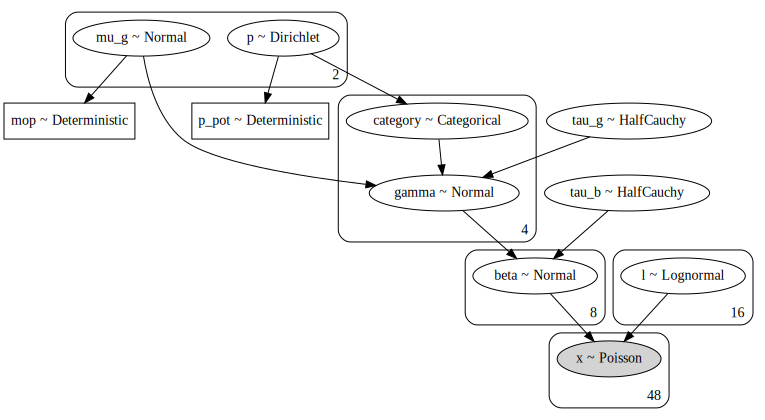

In [123]:
model_to_graphviz(model)

In [ ]:
with model:
    trace = pm.sample(100000, n_init=50000, tune=2500,
                      chains=4, init="advi", random_seed=seed)

In [133]:
az.rhat(trace).to_dataframe()

category  \
beta_dim_0 category_dim_0 gamma_dim_0 l_dim_0 mu_g_dim_0 p_dim_0 tau_b_dim_0 tau_g_dim_0             
0          0              0           0       0          0       0           0                 1.0   
                                                         1       0           0                 1.0   
                                              1          0       0           0                 1.0   
                                                         1       0           0                 1.0   
                                      1       0          0       0           0                 1.0   
                                                         1       0           0                 1.0   
                                              1          0       0           0                 1.0   
                                                         1       0           0                 1.0   
                                      2       0          0       0           0                 1.0   
                                                         1       0           0                 1.0   
                                              1          0       0           0                 1.0   
                                                         1       0           0                 1.0   
                                      3       0          0       0           0                 1.0   
                                                         1       0           0                 1.0   
                                              1          0       0           0                 1.0   
                                                         1       0           0                 1.0   
                                      4       0          0       0           0                 1.0   
                                                         1       0           0                 1.0   
                                              1          0       0           0                 1.0   
                                                         1       0           0                 1.0   
                                      5       0          0       0           0                 1.0   
                                                         1       0           0                 1.0   
                                              1          0       0           0                 1.0   
                                                         1       0           0                 1.0   
                                      6       0          0       0           0                 1.0   
                                                         1       0           0                 1.0   
                                              1          0       0           0                 1.0   
                                                         1       0           0                 1.0   
                                      7       0          0       0           0                 1.0   
                                                         1       0           0                 1.0   
...                                                                                            ...   
7          3              3           8       1          0       0           0                 1.0   
                                                         1       0           0                 1.0   
                                      9       0          0       0           0                 1.0   
                                                         1       0           0                 1.0   
                                              1          0       0           0                 1.0   
                                                         1       0           0                 1.0   
                                      10      0          0       0           0                 1.0   
          

In [134]:
az.effective_sample_size(trace).to_dataframe()

category  \
beta_dim_0 category_dim_0 gamma_dim_0 l_dim_0 mu_g_dim_0 p_dim_0 tau_b_dim_0 tau_g_dim_0             
0          0              0           0       0          0       0           0              3679.0   
                                                         1       0           0              3679.0   
                                              1          0       0           0              3679.0   
                                                         1       0           0              3679.0   
                                      1       0          0       0           0              3679.0   
                                                         1       0           0              3679.0   
                                              1          0       0           0              3679.0   
                                                         1       0           0              3679.0   
                                      2       0          0       0           0              3679.0   
                                                         1       0           0              3679.0   
                                              1          0       0           0              3679.0   
                                                         1       0           0              3679.0   
                                      3       0          0       0           0              3679.0   
                                                         1       0           0              3679.0   
                                              1          0       0           0              3679.0   
                                                         1       0           0              3679.0   
                                      4       0          0       0           0              3679.0   
                                                         1       0           0              3679.0   
                                              1          0       0           0              3679.0   
                                                         1       0           0              3679.0   
                                      5       0          0       0           0              3679.0   
                                                         1       0           0              3679.0   
                                              1          0       0           0              3679.0   
                                                         1       0           0              3679.0   
                                      6       0          0       0           0              3679.0   
                                                         1       0           0              3679.0   
                                              1          0       0           0              3679.0   
                                                         1       0           0              3679.0   
                                      7       0          0       0           0              3679.0   
                                                         1       0           0              3679.0   
...                                                                                            ...   
7          3              3           8       1          0       0           0              1178.0   
                                                         1       0           0              1178.0   
                                      9       0          0       0           0              1178.0   
                                                         1       0           0              1178.0   
                                              1          0       0           0              1178.0   
                                                         1       0           0              1178.0   
                                      10      0          0       0           0              1178.0   
          

In [129]:
gamma_true

array([-0.07417733,  0.02127506,  1.0186158 ,  1.06741494])

In [130]:
beta_true

array([-0.1129297 , -0.10921321, -0.01684367, -0.04037367,  0.84432371,
        1.08201822,  1.12188278,  0.96575195])

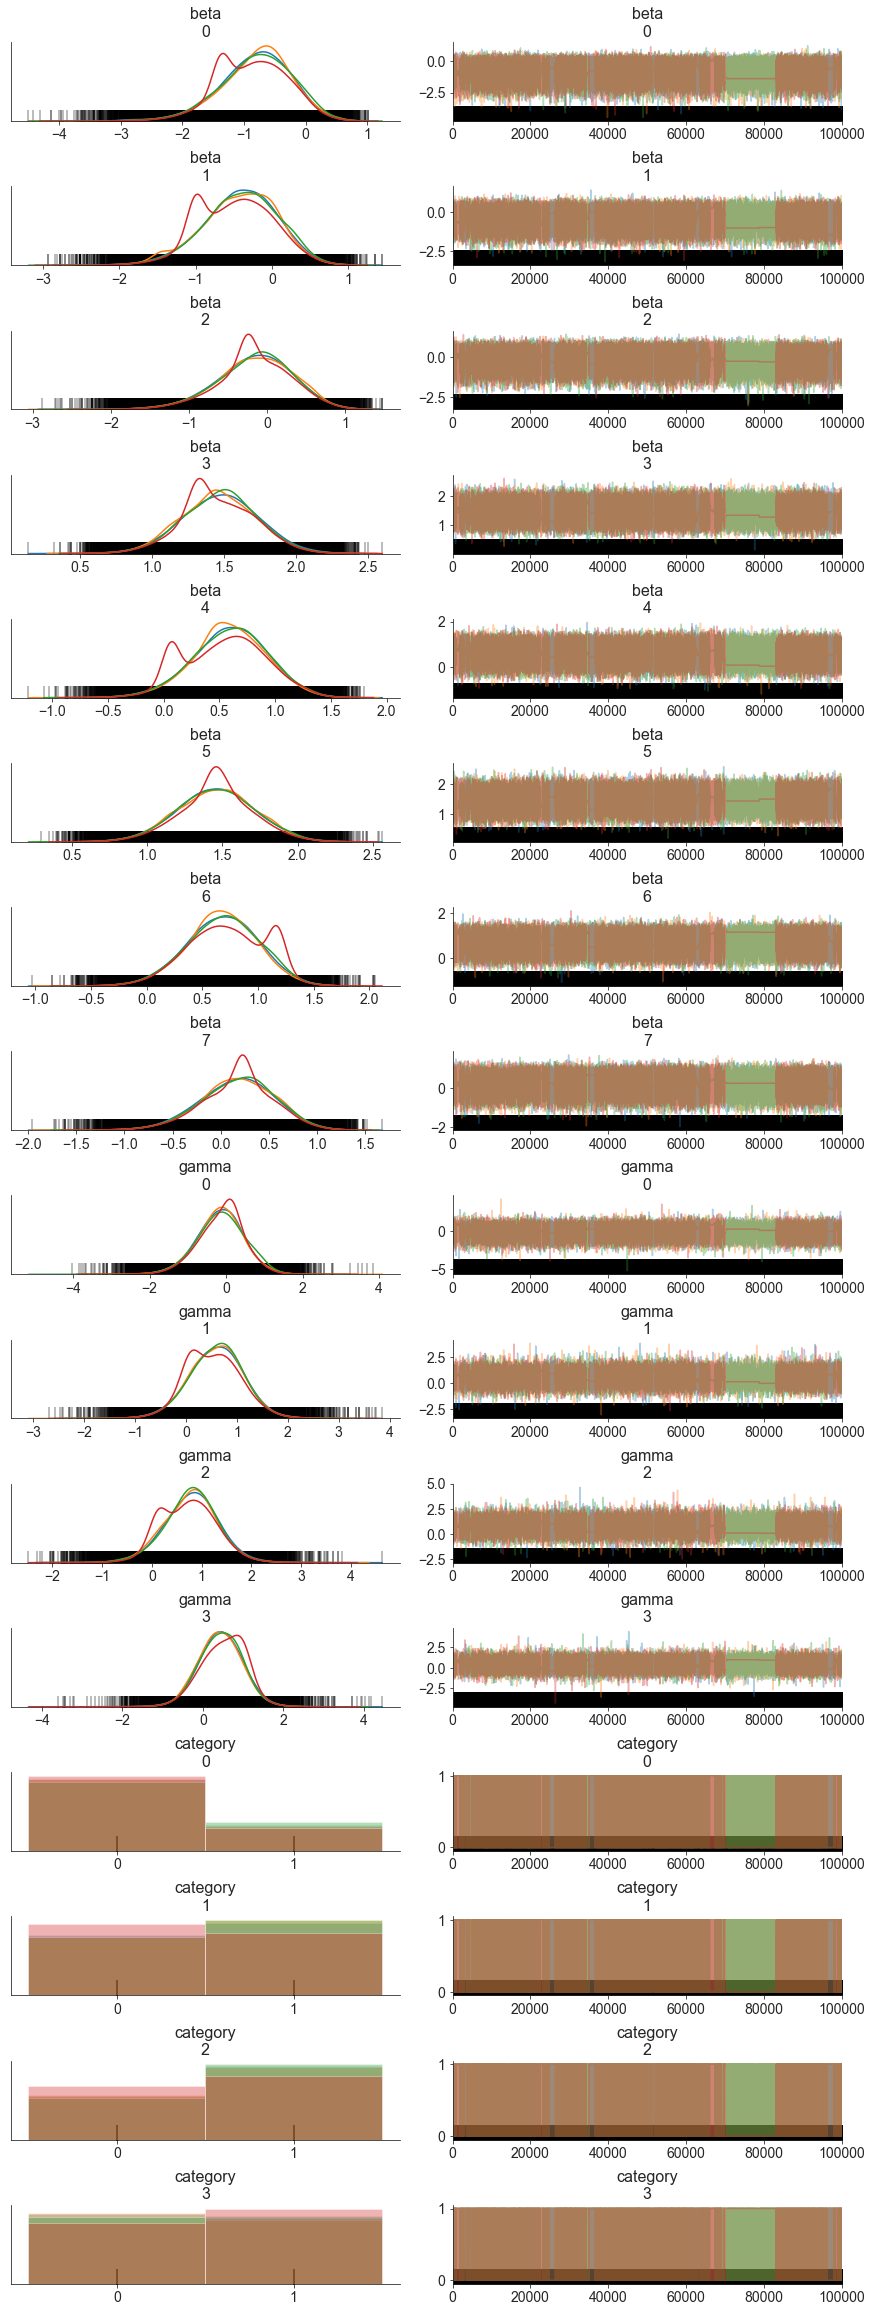

In [136]:
az.plot_trace(trace, var_names=["beta", "gamma", "category"]);